## Import required libraries

In [1]:
import pandas as pd
import numpy as np

import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, ndcg_score

import lightgbm as lgb
from lightgbm import LGBMRanker
from lightgbm import early_stopping, log_evaluation

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('data/clean_train.csv')
test_df = pd.read_csv('data/clean_test.csv')

## Load and prepare data for training

In [3]:
df = train_df

df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month
df = df.drop(columns=['date_time'])

df['relevance'] = df.apply(lambda x: 5 if x['booking_bool'] else (1 if x['click_bool'] else 0), axis=1)

X = df.drop(columns=['booking_bool', 'click_bool', 'relevance'])  # Features (exclude target and relevance score)
y = df['relevance']  # Relevance score as the target

groups = df['srch_id']


# GroupShuffleSplit (70% train, 30% eval) - ensuring same 'srch_id' stays in the same split
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Get train and validation split
for train_index, val_index in gss.split(X, y, groups=groups):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# Optional: Check group sizes
train_groups = X_train.groupby('srch_id').size()
val_groups = X_val.groupby('srch_id').size()

## Build & Train Model

In [4]:
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg',
    ndcg_eval_at=[5],  # Evaluate NDCG at top 5
    random_state=42,
    num_boost_round=3000,
    learning_rate=0.1
)

ranker.fit(
    X_train,  # Training features
    y_train,  # Relevance scores as the target
    group=train_groups,  # Grouping for ranking (items per query)
    eval_set=[(X_val, y_val)],  # Validation data
    eval_group=[val_groups],  # Grouping for validation data
    eval_metric='ndcg',  # Use NDCG as the evaluation metric
    eval_at=[5],  # Track NDCG@5
    callbacks=[early_stopping(stopping_rounds=50), lgb.log_evaluation(period=10)]  # Log evaluation every 10 rounds
)

[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4432
[LightGBM] [Info] Number of data points in the train set: 3471078, number of used features: 51
[LightGBM] [Warning] num_iterations is set=3000, num_boost_round=3000 will be ignored. Current value: num_iterations=3000
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@5: 0.343317
[20]	valid_0's ndcg@5: 0.350688
[30]	valid_0's ndcg@5: 0.353882
[40]	valid_0's ndcg@5: 0.356297
[50]	valid_0's ndcg@5: 0.358428
[60]	valid_0's ndcg@5: 0.360359
[70]	valid_0's ndcg@5: 0.361791
[80]	valid_0's ndcg@5: 0.36332
[90]	valid_0's ndcg@5: 0.364105
[100]	valid_0's ndcg@5: 0.365746
[110]	valid_0's ndcg

LGBMRanker(metric='ndcg', ndcg_eval_at=[5], num_boost_round=3000,
           objective='lambdarank', random_state=42)

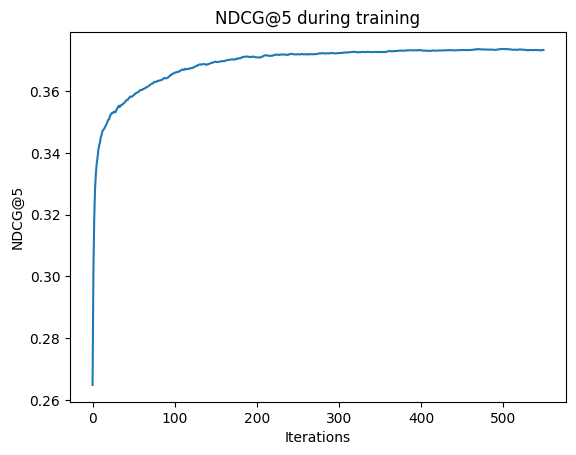

In [5]:
evals_result = ranker.evals_result_

plt.plot(evals_result['valid_0']['ndcg@5'])
plt.title("NDCG@5 during training")
plt.xlabel('Iterations')
plt.ylabel('NDCG@5')
plt.show()

In [6]:
# Predict relevance scores on the validation set
y_pred = ranker.predict(X_val)

# Calculate NDCG@5 (normalized discounted cumulative gain at rank 5)
ndcg_at_5 = ndcg_score([y_val], [y_pred], k=5)

print(f'NDCG@5 on Validation Set: {ndcg_at_5}')

NDCG@5 on Validation Set: 0.30078518014914984


## Predict and Save test results

In [7]:
X_train.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'srch_query_affinity_score', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate',
       'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_dif

In [8]:
test_df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,price_usd_norm,prop_starrating_norm
0,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,3180,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.268703,1.0
1,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,5543,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.258042,1.0
2,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,14142,2,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522407,1.0
3,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,22393,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524576,1.0
4,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,24194,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842248,1.0


In [9]:
# Process the test data (apply same transformations as for train data)
test_df['date_time'] = pd.to_datetime(test_df['date_time'])
test_df['month'] = test_df['date_time'].dt.month
test_df = test_df.drop(columns=['date_time'])

# Make predictions using the trained ranker model
y_pred_test = ranker.predict(test_df)

# Add predictions to the test data for ranking purposes
test_df['predicted_relevance'] = y_pred_test

# Sort the predictions by srch_id and predicted relevance (higher relevance first)
test_df_sorted = test_df.sort_values(by=['srch_id', 'predicted_relevance'], ascending=[True, False])

# Generate the submission file: srch_id, prop_id (top-ranked properties for each search)
submission = test_df_sorted[['srch_id', 'prop_id']]

# Save the submission file in the required format
submission.to_csv('submission.csv', index=False)